In [1]:
import os

import pandas as pd
import numpy as np
import random

from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import torch
import transformers
from transformers import (BertTokenizer,AutoTokenizer, BertForSequenceClassification, 
                          AdamW, get_linear_schedule_with_warmup)
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

## 1. Load Data To Analysis


In [2]:
# Load data
df = pd.read_csv('./data/reviews.csv',  
                 low_memory=False)
df
# reset index
# df.set_index('Id', inplace=True)

,Id,Review,Label
0,0,good and interesting,5
1,1,"This class is very helpful to me. Currently, I...",5
2,2,like!Prof and TAs are helpful and the discussi...,5
3,3,Easy to follow and includes a lot basic and im...,5
4,4,Really nice teacher!I could got the point eazl...,4
...,...,...,...
107013,107013,Trendy topic with talks from expertises in the...,4
107014,107014,"Wonderful! Simple and clear language, good ins...",5
107015,107015,an interesting and fun course. thanks. dr quincy,5
107016,107016,"very broad perspective, up to date information...",4


In [3]:
df.head()

,Id,Review,Label
0,0,good and interesting,5
1,1,"This class is very helpful to me. Currently, I...",5
2,2,like!Prof and TAs are helpful and the discussi...,5
3,3,Easy to follow and includes a lot basic and im...,5
4,4,Really nice teacher!I could got the point eazl...,4


Thông tin DataFrame:

- **Chỉ số (Index):** Range từ 0 đến 568453 (tổng cộng 568454 dòng).
- **Số cột:** 3 cột ("Id", "Score", "Text").
- **Kiểu dữ liệu cột:**
  - "Id" và "Score": int64.
  - "Text": object (chuỗi hoặc đối tượng không phải số).
- **Giá trị không phải null:**
  - Mỗi cột có 568454 giá trị không phải null.
- **Dung lượng bộ nhớ:** Khoảng 13.0 MB.

> 568454 - 568427 = 27 giá trị null

In [4]:
# Info Data:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107018 entries, 0 to 107017
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Id      107018 non-null  int64 
 1   Review  107018 non-null  object
 2   Label   107018 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 2.4+ MB


- `df`: Đây là tên của DataFrame, giả sử đã được định nghĩa trước đó trong mã.

- `df.Text`: Lấy cột có tên "Text" từ DataFrame `df`.

- `.iloc[10]`: Lấy giá trị ở dòng thứ 10 của cột "Text".

In [5]:
# check for null
df.isnull().sum()

Id        0
Review    0
Label     0
dtype: int64

> Xử lý xong các giá trị null, nếu có

In [6]:
df=df.rename(columns={'Review': 'Text', 'Label': 'Score'})

In [7]:
# Tạo ánh xạ từ điểm số sang nhãn cảm xúc
score_to_sentiment = {
    5: 'happy',
    4: 'satisfied',
    3: 'neutral',
    2: 'disappointed',
    1: 'angry'
}

# Thay đổi cột "Score" thành cột "Sentiment"
df['Sentiment'] = df['Score'].map(score_to_sentiment)

# Loại bỏ cột "Score" nếu không cần thiết
df = df.drop(columns=['Score'])

In [8]:
# delete null values
# Xóa các dòng có giá trị null
# check for null
df.isnull().sum()
# Info Data:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107018 entries, 0 to 107017
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Id         107018 non-null  int64 
 1   Text       107018 non-null  object
 2   Sentiment  107018 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.4+ MB


In [9]:
import pandas as pd
from sklearn.utils import resample
import random

# Giả sử df đã được tạo trước đó
# df = pd.read_csv('your_data.csv')  # Nếu bạn đang tải dữ liệu từ một tệp

# Kiểm tra thông tin ban đầu của DataFrame
print(df.info())

# Kiểm tra phân phối của các nhãn cảm xúc
print(df['Sentiment'].value_counts())

# Xác định số lượng mẫu mong muốn (chọn số lượng mẫu bằng với lớp nhỏ nhất)
split_num=3.5
min_samples = df['Sentiment'].value_counts().min()
base_balance = df.shape[0]//df['Sentiment'].unique().shape[0]//split_num - min_samples//2
def gen_random_balance():
    return random.randint(base_balance, base_balance + min_samples//3)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107018 entries, 0 to 107017
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Id         107018 non-null  int64 
 1   Text       107018 non-null  object
 2   Sentiment  107018 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.4+ MB
None
Sentiment
happy           79173
satisfied       18054
neutral          5071
angry            2469
disappointed     2251
Name: count, dtype: int64


In [10]:
# Tạo tập dữ liệu cân bằng
balanced_data = pd.DataFrame()

for sentiment in df['Sentiment'].unique():
    sentiment_data = df[df['Sentiment'] == sentiment]
    current_samples = len(sentiment_data)
    desired_samples = gen_random_balance()
    if current_samples > desired_samples:
        sentiment_samples = resample(sentiment_data, 
                                     replace=False, 
                                     n_samples=desired_samples, 
                                     random_state=42)
    else:
        sentiment_samples = resample(sentiment_data, 
                                     replace=True, 
                                     n_samples=desired_samples, 
                                     random_state=42)
    
    balanced_data = pd.concat([balanced_data, sentiment_samples])

# Kiểm tra kết quả cân bằng dữ liệu
print(balanced_data['Sentiment'].value_counts())


Sentiment
happy           5544
neutral         5491
angry           5015
disappointed    5014
satisfied       4998
Name: count, dtype: int64


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
df=balanced_data

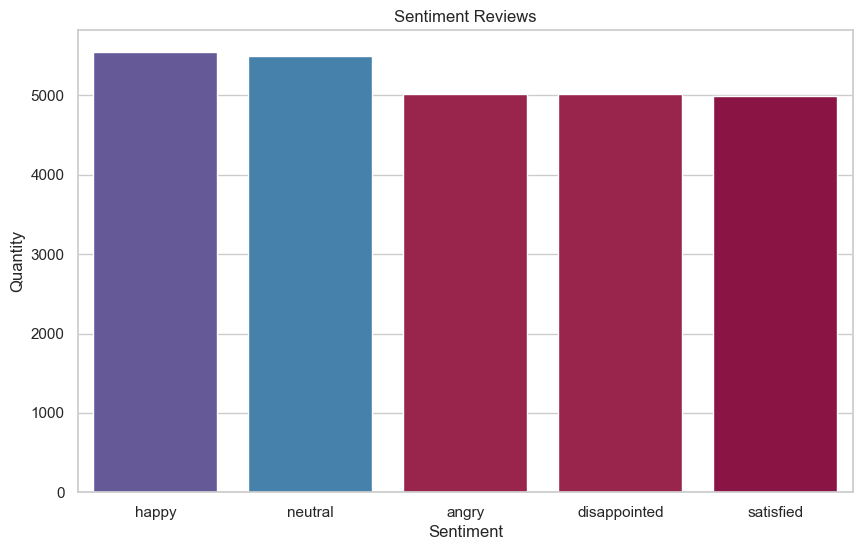

In [13]:
# Lấy Series từ df['Score'].value_counts()
score_counts = df['Sentiment'].value_counts()

# Thiết lập môi trường trực quan
sns.set(style="whitegrid", palette="pastel")

# Vẽ biểu đồ thanh
plt.figure(figsize=(10, 6))
sns.barplot(x=score_counts.index, y=score_counts.values,
            palette="Spectral", legend=False, hue=score_counts.values)
plt.title('Sentiment Reviews')
plt.xlabel('Sentiment')
plt.ylabel('Quantity')
plt.show()

In [14]:
# find the maximum length
max_len = max([len(text) for text in df.Text])
print('Max length: ', max_len)

Max length:  7766


In [15]:
### creating labels ###

possible_labels = df.Sentiment.unique()

## creating a dict to convert string categories to numbers ##

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
    
df['Label'] = df.Sentiment.replace(label_dict)
df.head()

,Id,Text,Sentiment,Label
79636,79636,Great course and great teacher. Great overview...,happy,0
54645,54645,I have been struggling to initiate Machine lea...,happy,0
39397,39397,Loved the class,happy,0
78360,78360,Very easy if you have a programming background...,happy,0
106982,106982,Great class!!!!,happy,0


In [16]:
label_dict

{'happy': 0, 'satisfied': 1, 'neutral': 2, 'disappointed': 3, 'angry': 4}

## 2. Spliting into Train, Test, Val


1. **`from sklearn.model_selection import train_test_split`**: 
   - Nhập hàm `train_test_split` từ scikit-learn để thực hiện chia dữ liệu thành tập huấn luyện và tập kiểm tra.

2. **`X_train, X_val, y_train, y_val = train_test_split(df.index.values, df.Score.values, test_size=0.15, random_state=17, stratify=df.Score.values)`**:
   - `df.index.values`: Chọn cột chỉ mục của DataFrame (`index`), giả sử rằng nó chứa các giá trị duy nhất hoặc độc lập.
   - `df.Score.values`: Chọn cột "Score" làm giá trị mục tiêu.
   - `test_size=0.15`: Thiết lập tỷ lệ tập kiểm tra là 15%, tỷ lệ tập huấn luyện là 85%.
   - `random_state=17`: Đặt một giá trị ngẫu nhiên để đảm bảo tái tạo kết quả nếu bạn muốn chạy lại mã và nhận được kết quả giống nhau.
   - `stratify=df.Score.values`: Thiết lập để đảm bảo phân phối của tập kiểm tra giữ nguyên tỷ lệ của các lớp (stratified sampling), đặc biệt quan trọng nếu dữ liệu không cân bằng theo các giá trị của "Score".

3. **`X_train, X_val, y_train, y_val`**:
   - `X_train`, `X_val`: Chứa các chỉ mục (index) của dữ liệu tương ứng trong tập huấn luyện và tập kiểm tra.
   - `y_train`, `y_val`: Chứa các giá trị "Score" tương ứng với tập huấn luyện và tập kiểm tra.

Tổng cộng, đoạn mã này chia dữ liệu thành tập huấn luyện và tập kiểm tra, sử dụng 85% dữ liệu cho tập huấn luyện và 15% cho tập kiểm tra, và giữ nguyên tỷ lệ của các lớp trong quá trình chia dữ liệu. Điều này làm cho mô hình có thể học từ một phân phối dữ liệu tương tự như dữ liệu gốc.

In [17]:
from sklearn.model_selection import train_test_split

# train test split
X_train, X_val, y_train, y_val = train_test_split(df.index.values,
                                                  df.Sentiment.values,
                                                  test_size=0.15,
                                                  random_state=17,
                                                  stratify=df.Sentiment.values)
# create new column
df['data_type'] = ['not_set'] * df.shape[0]
df.head()

,Id,Text,Sentiment,Label,data_type
79636,79636,Great course and great teacher. Great overview...,happy,0,not_set
54645,54645,I have been struggling to initiate Machine lea...,happy,0,not_set
39397,39397,Loved the class,happy,0,not_set
78360,78360,Very easy if you have a programming background...,happy,0,not_set
106982,106982,Great class!!!!,happy,0,not_set


In [18]:
# fill in data type
df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'


In [19]:
df.groupby(['Sentiment','data_type']).count()

Id  Text  Label
Sentiment    data_type                   
angry        train      3141  3141   3141
             val        1874  1874   1874
disappointed train      3025  3025   3025
             val        1989  1989   1989
happy        train      4712  4712   4712
             val         832   832    832
neutral      train      3907  3907   3907
             val        1584  1584   1584
satisfied    train      4248  4248   4248
             val         750   750    750

## Tokenizing data

In [20]:
# Using the BERT tokenizer from the 'bert-base-uncased' model
# and setting do_lower_case to True to ensure all text is lowercased
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)

# Encoding the text data in the training set using batch_encode_plus
# This method tokenizes and encodes a batch of sequences, adding special tokens,
# padding the sequences to the same length, and returning PyTorch tensors
encoded_data_train = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].Text.values,            # Extracting text data for training
    add_special_tokens=True,                          # Adding special tokens like [CLS] and [SEP]
    return_attention_mask=True,                      # Returning attention masks to focus on actual tokens
    pad_to_max_length=True,                          # Padding sequences to the same length
    max_length=256,                                   # Maximum length of each sequence
    return_tensors='pt'                               # Returning PyTorch tensors
)

# Encoding the text data in the validation set using batch_encode_plus
encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].Text.values,              # Extracting text data for validation
    add_special_tokens=True,                          # Adding special tokens like [CLS] and [SEP]
    return_attention_mask=True,                      # Returning attention masks to focus on actual tokens
    pad_to_max_length=True,                          # Padding sequences to the same length
    max_length=256,                                   # Maximum length of each sequence
    return_tensors='pt'                               # Returning PyTorch tensors
)

# Extracting input IDs, attention masks, and labels for the training set
input_ids_train = encoded_data_train['input_ids']     # Input IDs representing tokenized text
attention_masks_train = encoded_data_train['attention_mask']  # Attention masks indicating which tokens to attend to
labels_train = torch.tensor(df[df.data_type=='train'].Label.values)  # Labels for the training set

# Extracting input IDs, attention masks, and labels for the validation set
input_ids_val = encoded_data_val['input_ids']         # Input IDs representing tokenized text
attention_masks_val = encoded_data_val['attention_mask']   # Attention masks indicating which tokens to attend to
labels_val = torch.tensor(df[df.data_type=='val'].Label.values)   # Labels for the validation set

# Creating PyTorch datasets for training and validation
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)  # Training dataset
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)          # Validation dataset

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
d:\Big_Project\Mashine-Learning---RoBerta---Base-Bert\venv\lib\site-packages\transformers\tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


## Bert Set up

In [21]:
# Initializing the BERT model for sequence classification from the pre-trained 'bert-base-uncased' model
# Specifying the number of labels in the output layer based on the length of the label dictionary
# Setting output_attentions and output_hidden_states to False to exclude additional outputs
# Setting resume_download to True to resume download if interrupted
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                                        num_labels=len(label_dict),
                                                        output_attentions=False,
                                                        output_hidden_states=False)
model.load_state_dict(torch.load('../model/fintune-v1_epoch_7.model'))

# Defining the batch size for training and validation
batch_size = 16

# Creating data loaders for training and validation sets
# Using RandomSampler for training data and SequentialSampler for validation data
dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

# Initializing the AdamW optimizer with the BERT model parameters
# Setting the learning rate to 2e-5 and epsilon to 1e-8
optimizer = AdamW(model.parameters(),
                  lr=2e-5, 
                  eps=1e-8)

# Defining the number of epochs for training
epochs = 7

# Creating a linear scheduler with warmup for adjusting learning rates during training
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

# Defining a function to calculate the F1 score
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

# Defining a function to calculate accuracy per class
def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
d:\Big_Project\Mashine-Learning---RoBerta---Base-Bert\venv\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## Creating our Training Loop
Approach adapted from an older version of HuggingFace's run_glue.py script. Accessible here.

In [22]:
### assigning seed to be able to reproduce results ###
seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [23]:
# Checking for GPU availability and assigning the device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)  # Moving the model to the selected device
print(device)  # Printing the device (GPU or CPU) being used

# Defining the evaluation function for the validation set
def evaluate(dataloader_val):

    model.eval()  # Setting the model to evaluation mode
    
    loss_val_total = 0  # Initializing total validation loss
    predictions, true_vals = [], []  # Lists to store predictions and true values
    
    # Iterating through batches in the validation dataloader
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)  # Moving batch tensors to the device
        
        inputs = {'input_ids':      batch[0],      # Input token IDs
                  'attention_mask': batch[1],      # Attention masks
                  'labels':         batch[2],      # Labels
                 }

        with torch.no_grad():  # Disabling gradient calculation        
            outputs = model(**inputs)  # Forward pass
            
        loss = outputs[0]  # Extracting loss value from the output
        logits = outputs[1]  # Predicted logits
        loss_val_total += loss.item()  # Accumulating validation loss

        logits = logits.detach().cpu().numpy()  # Detaching logits from computation graph and moving to CPU
        label_ids = inputs['labels'].cpu().numpy()  # Moving label IDs to CPU
        predictions.append(logits)  # Appending predictions to the list
        true_vals.append(label_ids)  # Appending true values to the list
    
    loss_val_avg = loss_val_total/len(dataloader_val)  # Calculating average validation loss
    
    # Concatenating predictions and true values to form arrays
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals  # Returning validation loss, predictions, and true values

cuda


In [24]:
import json
def write_json(data, filename):
    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=4)

In [25]:
# Training loop for each epoch
cnt=0
for epoch in tqdm(range(1, epochs+1)):
    # Clear out accumulated gradients
    torch.cuda.empty_cache()
    
    model.train()  # Setting the model to training mode
    
    loss_train_total = 0  # Initializing total training loss

    # Progress bar for training epoch
    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()  # Resetting gradients
        
        batch = tuple(b.to(device) for b in batch)  # Moving batch tensors to the device
        
        inputs = {'input_ids':      batch[0],      # Input token IDs
                  'attention_mask': batch[1],      # Attention masks
                  'labels':         batch[2],      # Labels
                 }       

        outputs = model(**inputs)  # Forward pass
        
        loss = outputs[0]  # Extracting loss value from the output
        loss_train_total += loss.item()  # Accumulating training loss
        loss.backward()  # Backpropagation

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Clipping gradients to prevent explosion
        
        optimizer.step()  # Optimizer step
        scheduler.step()  # Scheduler step
        
        # Updating progress bar with current training loss
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
    # Saving model after each epoch
    torch.save(model.state_dict(), f'../model/finetuned_BERT_epoch_{epoch}.model')  # Saving model after each epoch
    
    tqdm.write(f'\nEpoch {epoch}')  # Printing current epoch
    
    loss_train_avg = loss_train_total/len(dataloader_train)  # Calculating average training loss
    tqdm.write(f'Training loss: {loss_train_avg}')  # Printing training loss
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)  # Evaluating on validation set
    val_f1 = f1_score_func(predictions, true_vals)  # Calculating F1 score
    tqdm.write(f'Validation loss: {val_loss}')  # Printing validation loss
    tqdm.write(f'F1 Score (Weighted): {val_f1}')  # Printing F1 score
    write_json({'epoch': epoch, 'training_loss': loss_train_avg, 'validation_loss': val_loss, 'f1_score': val_f1}, f'../model/finetuned_BERT_epoch_{epoch}.json')  # Saving metrics

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/1190 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.23968944261559802
Validation loss: 0.2785079166256103
F1 Score (Weighted): 0.9351330956904895


Epoch 2:   0%|          | 0/1190 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.15510905542579173
Validation loss: 0.34780235129589776
F1 Score (Weighted): 0.9275126344975039


Epoch 3:   0%|          | 0/1190 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.10412546880841607
Validation loss: 0.33856292887612655
F1 Score (Weighted): 0.9367355921224214


Epoch 4:   0%|          | 0/1190 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.07788582270935143
Validation loss: 0.4514781580346938
F1 Score (Weighted): 0.9219381569854098


Epoch 5:   0%|          | 0/1190 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.056756867981440494
Validation loss: 0.4633216830826066
F1 Score (Weighted): 0.9253785338608764


Epoch 6:   0%|          | 0/1190 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.0467541970686176
Validation loss: 0.46365585163737044
F1 Score (Weighted): 0.9297043484504416


Epoch 7:   0%|          | 0/1190 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.03774469992479245
Validation loss: 0.46583516240339534
F1 Score (Weighted): 0.9311594099972864


In [26]:
accuracy_per_class(predictions, true_vals)

Class: happy
Accuracy: 792/832

Class: satisfied
Accuracy: 703/750

Class: neutral
Accuracy: 1452/1584

Class: disappointed
Accuracy: 1830/1989

Class: angry
Accuracy: 1766/1874



In [27]:
792/832

0.9519230769230769